# 📋 01 — Data Preparation

**Purpose:** Generate manifests, extract hybrid ROI crops, create tar archives, and audit quality.

**Sections:**
1. Inline Setup (run if starting fresh)
2. Manifest & Split Generation
3. Hybrid ROI Extraction (face, face_hands)
4. **Create Tar Archives (ONE-TIME)** — for fast data loading in future sessions
5. Quality Audit & Thesis Figures

**Prerequisites:** Original images exist on Google Drive at `DRIVE_DATA_ROOT/auc.distracted.driver.dataset_v2/`


## 🔧 Section 1: Inline Setup

Run these cells if starting this notebook fresh (not coming from 00_setup.ipynb).


In [1]:
# --- INLINE SETUP (run if starting fresh) ---
import os, subprocess, sys

# Config
REPO_URL       = "https://github.com/ClaudiaCPach/CNNs-distracted-driving"
REPO_DIRNAME   = "CNNs-distracted-driving"
BRANCH         = "main"
PROJECT_ROOT   = f"/content/{REPO_DIRNAME}"
DRIVE_PATH     = "/content/drive/MyDrive/TFM"
DRIVE_DATA_ROOT = f"{DRIVE_PATH}/data"
FAST_DATA      = "/content/data"
DATASET_ROOT   = DRIVE_DATA_ROOT
OUT_ROOT       = f"{DRIVE_PATH}/outputs"
CKPT_ROOT      = f"{DRIVE_PATH}/checkpoints"

# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Clone/update repo
def sh(cmd):
    print(f"$ {cmd}")
    rc = subprocess.call(cmd, shell=True, executable="/bin/bash")
    if rc != 0:
        raise RuntimeError(f"Command failed: {cmd}")

if os.path.isdir(PROJECT_ROOT):
    sh(f"cd {PROJECT_ROOT} && git pull --rebase origin {BRANCH}")
else:
    sh(f"git clone --branch {BRANCH} {REPO_URL} {PROJECT_ROOT}")

# Install
sh(f"pip install -q -e {PROJECT_ROOT}")

# Set env vars
os.environ["DRIVE_PATH"] = DRIVE_PATH
os.environ["DATASET_ROOT"] = DATASET_ROOT
os.environ["OUT_ROOT"] = OUT_ROOT
os.environ["CKPT_ROOT"] = CKPT_ROOT
os.environ["FAST_DATA"] = FAST_DATA

sys.path.insert(0, PROJECT_ROOT)
sys.path.insert(0, os.path.join(PROJECT_ROOT, "src"))

print("✅ Inline setup complete")


Mounted at /content/drive
$ git clone --branch main https://github.com/ClaudiaCPach/CNNs-distracted-driving /content/CNNs-distracted-driving
$ pip install -q -e /content/CNNs-distracted-driving
✅ Inline setup complete


## 📋 Section 2: Manifest & Split Generation

Generate manifest.csv and train/val/test split CSVs. **Run once** — results persist on Drive.


In [ ]:
# Run the manifest generator
import subprocess
import sys

sys.path.insert(0, PROJECT_ROOT)

manifest_cmd = f"cd {PROJECT_ROOT} && python -m ddriver.data.manifest --write-split-lists"

print("🔨 Generating manifest and split CSVs...")
print(f"Running: {manifest_cmd}\n")

result = subprocess.run(manifest_cmd, shell=True, capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print("Warnings/Errors:", result.stderr)

if result.returncode == 0:
    print("\n✅ Manifest and split CSVs generated successfully!")
    print(f"   Manifest: {os.environ['OUT_ROOT']}/manifests/manifest.csv")
    print(f"   Train: {os.environ['OUT_ROOT']}/splits/train.csv")
    print(f"   Val: {os.environ['OUT_ROOT']}/splits/val.csv")
    print(f"   Test: {os.environ['OUT_ROOT']}/splits/test.csv")
else:
    print(f"\n❌ Error (exit code {result.returncode})")
    raise RuntimeError("Manifest generation failed")


In [ ]:
# Verify CSVs were created
import pandas as pd
from pathlib import Path

manifest_path = Path(os.environ['OUT_ROOT']) / "manifests" / "manifest.csv"
train_path = Path(os.environ['OUT_ROOT']) / "splits" / "train.csv"
val_path = Path(os.environ['OUT_ROOT']) / "splits" / "val.csv"
test_path = Path(os.environ['OUT_ROOT']) / "splits" / "test.csv"

print("📊 Checking CSV files...\n")
for name, path in [("Manifest", manifest_path), ("Train", train_path), ("Val", val_path), ("Test", test_path)]:
    if path.exists():
        df = pd.read_csv(path)
        print(f"✅ {name}: {len(df)} rows, columns: {list(df.columns)}")
    else:
        print(f"❌ {name}: File not found at {path}")

if manifest_path.exists():
    print("\n📄 Sample from manifest (first 3 rows):")
    sample = pd.read_csv(manifest_path).head(3)
    print(sample[['path', 'class_id', 'driver_id', 'camera', 'split']].to_string())


In [ ]:
# Create a tiny balanced subset for quick testing (20 images per class)
import pandas as pd
from pathlib import Path
from ddriver import config

train_csv = Path(config.OUT_ROOT) / "splits" / "train.csv"
train_small_csv = Path(config.OUT_ROOT) / "splits" / "train_small.csv"

print(f"Reading {train_csv}...")
df = pd.read_csv(train_csv)

small = df.groupby("class_id").head(20)

print(f"Original train.csv: {len(df)} images")
print(f"Small subset: {len(small)} images ({len(small) // 10} per class)")
print(f"\nClass distribution:")
print(small["class_id"].value_counts().sort_index())

small.to_csv(train_small_csv, index=False)
print(f"\n✅ Saved to {train_small_csv}")


## 🔀 Section 3: Hybrid ROI Extraction (InsightFace + MediaPipe Hands)

Extract face and face+hands crops using the hybrid pipeline. **Run once per variant** — results persist on Drive.


In [ ]:
# Install extraction dependencies
!pip -q install insightface onnxruntime mediapipe


In [ ]:
!pip install mediapipe==0.10.13

In [ ]:
# 🔀 Hybrid ROI Extraction — FACE variant
import subprocess
from pathlib import Path

VARIANT = "face"  # <<<< CHANGE TO "face_hands" for second run

# Output location (Drive for persistence)
HYBRID_OUTPUT_ROOT = Path(OUT_ROOT) / "hybrid"

manifest_csv = Path(OUT_ROOT) / "manifests" / "manifest.csv"
splits_root = Path(OUT_ROOT) / "splits"

# Auto-detect local vs Drive images
LOCAL_DATASET_ROOT = Path("/content/data/auc.distracted.driver.dataset_v2")
DRIVE_DATASET_ROOT = Path(DATASET_ROOT)

if LOCAL_DATASET_ROOT.exists() and any(LOCAL_DATASET_ROOT.iterdir()):
    EFFECTIVE_DATASET_ROOT = LOCAL_DATASET_ROOT
    print(f"🚀 Using local images from {LOCAL_DATASET_ROOT}")
else:
    EFFECTIVE_DATASET_ROOT = DRIVE_DATASET_ROOT
    print(f"📁 Using images from Drive: {DRIVE_DATASET_ROOT}")

# Test mode options
TEST_MODE = False  # Set True for quick test
LIMIT = None  # Set to e.g. 50 for debugging

sample_flag = ""
limit_flag = f"--limit {LIMIT}" if LIMIT else ""

extract_cmd = f"""
cd {PROJECT_ROOT}
python -m src.ddriver.data.hybrid_extract \
  --manifest {manifest_csv} \
  --splits-root {splits_root} \
  --dataset-root {EFFECTIVE_DATASET_ROOT} \
  --output-root {HYBRID_OUTPUT_ROOT} \
  --variant {VARIANT} \
  --min-face-conf 0.4 \
  --min-detection-area-frac 0.005 \
  --min-area-frac 0.01 \
  --min-aspect 0.08 \
  --pad-frac 0.35 \
  --max-area-frac 0.40 \
  {limit_flag} \
  --overwrite
"""

# # for face_hands settings:
# extract_cmd = f"""
# cd {PROJECT_ROOT}
# python -m src.ddriver.data.hybrid_extract \
#   --manifest {manifest_csv} \
#   --splits-root {splits_root} \
#   --dataset-root {EFFECTIVE_DATASET_ROOT} \
#   --output-root {HYBRID_OUTPUT_ROOT} \
#   --variant {VARIANT} \
#   --min-face-conf 0.4 \
#   --min-detection-area-frac 0.01 \
#   --min-area-frac 0.02 \
#   --min-aspect 0.10 \
#   --pad-frac 0.30 \
#   {sample_flag} \
#   {limit_flag} \
#   --overwrite
# """

print(f"Running Hybrid extraction for variant: {VARIANT}")
print(extract_cmd)
proc = subprocess.Popen(extract_cmd, shell=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
for line in proc.stdout:
    print(line, end="")
proc.wait()
if proc.returncode != 0:
    raise RuntimeError("Hybrid extraction failed.")


In [ ]:
# 🔁 Regenerate Hybrid CSVs (manifest + splits) for the extracted variant
from pathlib import Path
import pandas as pd

# VARIANT should match what you just extracted
VARIANT = VARIANT if 'VARIANT' in globals() else 'face'
HYBRID_OUTPUT_ROOT = HYBRID_OUTPUT_ROOT if 'HYBRID_OUTPUT_ROOT' in globals() else Path(OUT_ROOT) / 'hybrid'

manifest_csv = Path(OUT_ROOT) / 'manifests' / 'manifest.csv'
splits_root = Path(OUT_ROOT) / 'splits'
crop_root = Path(HYBRID_OUTPUT_ROOT) / VARIANT
meta_csv = Path(HYBRID_OUTPUT_ROOT) / f'detection_metadata_{VARIANT}.csv'

def _extract_class(path_str):
    for part in Path(path_str).parts:
        if len(part) == 2 and part.startswith('c') and part[1].isdigit():
            return part
    return None

def _extract_camera(path_str):
    for part in Path(path_str).parts:
        if part.lower().startswith('camera'):
            return part
    return None

def _extract_orig_split(path_str):
    """Extract the original dataset split folder (train/test) from path."""
    for part in Path(path_str).parts:
        if part.lower() in ('train', 'test'):
            return part.lower()
    return None

def _extract_filename(path_str):
    return Path(path_str).name

def _coerce_class_id(value):
    if pd.isna(value):
        return None
    value_str = str(value)
    if len(value_str) == 2 and value_str.startswith('c') and value_str[1].isdigit():
        return value_str
    if value_str.isdigit():
        return f'c{int(value_str)}'
    return None

def _normalize_camera(cam):
    if cam is None or pd.isna(cam):
        return None
    cam_str = str(cam).lower().replace(' ', '')
    if cam_str in ['camera1', 'cam1']:
        return 'cam1'
    if cam_str in ['camera2', 'cam2']:
        return 'cam2'
    return cam_str

print(f'📂 Loading original manifest: {manifest_csv}')
orig_df = pd.read_csv(manifest_csv)
orig_df = orig_df.rename(columns={'path': 'original_path'})
orig_df['_filename'] = orig_df['original_path'].astype(str).map(_extract_filename)
orig_df['_class'] = orig_df['original_path'].astype(str).map(_extract_class)
orig_df['_camera'] = orig_df['original_path'].astype(str).map(_extract_camera).map(_normalize_camera)
orig_df['_orig_split'] = orig_df['original_path'].astype(str).map(_extract_orig_split)

print(f'🔍 Scanning crops: {crop_root}')
crop_paths = list(crop_root.rglob('*.jpg'))
crop_df = pd.DataFrame({'crop_path': [str(p) for p in crop_paths]})
crop_df['path'] = crop_df['crop_path'].map(lambda p: str(Path(p).relative_to(HYBRID_OUTPUT_ROOT)))
crop_df['_filename'] = crop_df['crop_path'].map(_extract_filename)
crop_df['_class'] = crop_df['crop_path'].map(_extract_class)
crop_df['_camera'] = crop_df['crop_path'].map(_extract_camera).map(_normalize_camera)
crop_df['_orig_split'] = crop_df['crop_path'].map(_extract_orig_split)

fallback_paths = set()
if meta_csv.exists():
    meta_df = pd.read_csv(meta_csv)
    meta_df = meta_df[meta_df['cropped_path'].astype(str).str.len() > 0]
    meta_df['path'] = meta_df['cropped_path'].astype(str)
    meta_df['_class'] = meta_df['class_id'].map(_coerce_class_id)
    meta_df['_camera'] = meta_df['camera'].map(_normalize_camera)
    crop_df = crop_df.merge(
        meta_df[['path', '_class', '_camera', 'fallback_to_full']],
        on='path', how='left', suffixes=('', '_meta'),
    )
    crop_df['_class'] = crop_df['_class'].fillna(crop_df['_class_meta'])
    crop_df['_camera'] = crop_df['_camera'].fillna(crop_df['_camera_meta'])
    crop_df = crop_df.drop(columns=['_class_meta', '_camera_meta'], errors='ignore')
    fallback_paths = set(meta_df.loc[meta_df['fallback_to_full'] == True, 'path'].dropna().astype(str))
    print(f'🚫 Excluding {len(fallback_paths)} fallback crops from splits')

crop_df_all = crop_df.copy()
crop_df = crop_df[~crop_df['path'].isin(fallback_paths)]

# Merge key includes orig_split to distinguish Camera1/train/c0/551.jpg from Camera1/test/c0/551.jpg
merge_keys = ['_filename', '_class', '_camera', '_orig_split']
merged = crop_df_all.merge(orig_df, on=merge_keys, how='left')
manifest_out = merged.drop(columns=['crop_path', '_filename', '_class', '_camera', '_orig_split'], errors='ignore')
manifest_out_path = Path(HYBRID_OUTPUT_ROOT) / f'manifest_{VARIANT}.csv'
manifest_out.to_csv(manifest_out_path, index=False)
print(f'✅ Wrote manifest: {manifest_out_path}')

for split_name in ['train', 'val', 'test']:
    split_path = splits_root / f'{split_name}.csv'
    split_df = pd.read_csv(split_path)
    split_df['path'] = split_df['path'].astype(str)
    split_df['_filename'] = split_df['path'].map(_extract_filename)
    split_df['_class'] = split_df['path'].map(_extract_class)
    split_df['_camera'] = split_df['path'].map(_extract_camera).map(_normalize_camera)
    split_df['_orig_split'] = split_df['path'].map(_extract_orig_split)

    split_merged = split_df.merge(crop_df, on=merge_keys, how='inner')
    split_merged['original_path'] = split_merged['path_x']
    split_merged['path'] = split_merged['path_y']
    cols_to_drop = ['path_x', 'path_y', '_filename', '_class', '_camera', '_orig_split', 'crop_path', 'fallback_to_full']
    split_merged = split_merged.drop(columns=[c for c in cols_to_drop if c in split_merged.columns])

    out_split = Path(HYBRID_OUTPUT_ROOT) / f'{split_name}_{VARIANT}.csv'
    split_merged.to_csv(out_split, index=False)
    print(f'✅ Wrote split: {out_split} ({len(split_merged)} rows)')


## 🎯 Section 3b: Generate Control Splits (5-Run Plan)

Generate filtered split CSVs for the experimental control runs. This creates full-frame splits filtered to the same images that have face/face+hands crops available.

**Run once** after extracting both face and face_hands variants — results persist on Drive.


In [ ]:
# 🎯 Generate Control Splits for 5-Run Experimental Plan
from pathlib import Path
from ddriver.data.id_sets import (
    extract_id_sets,
    generate_control_splits,
    save_id_sets,
    print_id_set_summary,
)

# Paths to manifests
manifest_full = Path(OUT_ROOT) / "manifests" / "manifest.csv"
manifest_face = Path(OUT_ROOT) / "hybrid" / "manifest_face.csv"
manifest_fh = Path(OUT_ROOT) / "hybrid" / "manifest_face_hands.csv"

# Verify manifests exist
missing = []
for name, path in [("Full-frame", manifest_full), ("Face", manifest_face), ("Face+Hands", manifest_fh)]:
    if not path.exists():
        missing.append(f"{name}: {path}")

if missing:
    print("⚠️  Missing manifests (run hybrid extraction first):")
    for m in missing:
        print(f"   - {m}")
    raise FileNotFoundError("Run hybrid extraction for both face and face_hands variants first.")

# Extract ID sets from manifests
print("🔍 Extracting ID sets from manifests...")
id_sets = extract_id_sets(
    manifest_full=manifest_full,
    manifest_face=manifest_face,
    manifest_fh=manifest_fh,
)
print_id_set_summary(id_sets)

# Save ID sets for reference/auditing
id_sets_dir = Path(OUT_ROOT) / "splits" / "id_sets"
print(f"\n💾 Saving ID sets to {id_sets_dir}...")
save_id_sets(id_sets, id_sets_dir)

# Generate control split CSVs
splits_root = Path(OUT_ROOT) / "splits"
control_output = Path(OUT_ROOT) / "splits" / "control"

print("\n🔧 Generating control splits...")
results = generate_control_splits(
    splits_root=splits_root,
    id_sets=id_sets,
    output_root=control_output,
    generate_both=True,  # Also generate S_both splits
)

print(f"\n✅ Control splits saved to: {control_output}")
print("\n📁 Generated files:")
for subset_name, splits in results.items():
    for split_name, path in splits.items():
        print(f"   {subset_name}/{split_name}: {path.name}")


## 📦 Section 4: Create Tar Archives (ONE-TIME)

Create tar archives of hybrid crops for **fast loading in future sessions**.

Copying ~13,000 small files one-by-one over the Drive FUSE mount takes 2+ hours.
A single tar archive can be copied in ~5 minutes and extracted instantly.

**Run these cells ONCE** after extracting hybrid crops. The archives persist on Drive.


In [ ]:
# 📦 Create Tar Archives for Hybrid Crops (ONE-TIME)
# Run this ONCE after extracting hybrid crops. Archives persist on Drive.

from pathlib import Path
from ddriver.data.fastcopy import create_tar_archive

DRIVE_ROOT = Path(OUT_ROOT) / "hybrid"
TAR_OUTPUT_DIR = DRIVE_ROOT  # Save tars alongside hybrid folder

# Create archives for both variants
for variant in ["face", "face_hands"]:
    source_dir = DRIVE_ROOT / variant
    tar_path = TAR_OUTPUT_DIR / f"hybrid_{variant}.tar"

    if not source_dir.exists():
        print(f"⚠️  {variant}: Source not found at {source_dir}")
        continue

    if tar_path.exists():
        size_mb = tar_path.stat().st_size / (1024 * 1024)
        print(f"✅ {variant}: Archive already exists ({size_mb:.1f} MB)")
        continue

    print(f"\n{'='*60}")
    print(f"📦 Creating tar archive for: {variant}")
    print(f"{'='*60}")

    result = create_tar_archive(
        source_dir=source_dir,
        tar_path=tar_path,
        use_gzip=False,  # Faster extraction, JPEG already compressed
        verbose=True,
    )

    print(f"   ✅ Created: {tar_path}")

print("\n" + "="*60)
print("📋 Archive Summary")
print("="*60)
for variant in ["face", "face_hands"]:
    tar_path = TAR_OUTPUT_DIR / f"hybrid_{variant}.tar"
    if tar_path.exists():
        size_mb = tar_path.stat().st_size / (1024 * 1024)
        print(f"   ✅ hybrid_{variant}.tar: {size_mb:.1f} MB")
    else:
        print(f"   ❌ hybrid_{variant}.tar: Not created")

print("\n💡 These archives will be used in 02_training.ipynb for fast data loading.")


## 📦 Section 4b: Create Full-Frame Compressed Tar (ONE-TIME)

Create a tar archive of **compressed full-frame images** for fast loading.

This involves:
1. Compressing images to 320px (shorter side) at 80% JPEG quality
2. Creating a tar archive

**Run ONCE** — the archive persists on Drive for all future sessions.


In [ ]:
# 📦 Create Full-Frame Compressed Tar Archive (ONE-TIME)
# This cell compresses full-frame images and creates a tar for fast loading.

from pathlib import Path
import shutil
from ddriver.data.fastcopy import (
    CompressionSpec,
    copy_splits_with_compression,
    create_tar_archive,
)

# Check if tar already exists
FULL_TAR_PATH = Path(DRIVE_DATA_ROOT) / "full_compressed.tar"

if FULL_TAR_PATH.exists():
    size_mb = FULL_TAR_PATH.stat().st_size / (1024 * 1024)
    print(f"✅ Full-frame tar already exists: {FULL_TAR_PATH}")
    print(f"   Size: {size_mb:.1f} MB")
    print("   Skipping creation. Delete the tar file if you want to recreate it.")
else:
    print("📦 Creating compressed full-frame tar archive...")
    print("   This is a ONE-TIME operation (may take 30-60 minutes).")
    print()

    # Step 1: Compress images to /content (temporary)
    SRC_ROOT = Path(DRIVE_DATA_ROOT) / "auc.distracted.driver.dataset_v2"
    DST_ROOT = Path("/content/data/full_compressed")

    split_csvs = {
        "train": Path(OUT_ROOT) / "splits" / "train.csv",
        "val": Path(OUT_ROOT) / "splits" / "val.csv",
        "test": Path(OUT_ROOT) / "splits" / "test.csv",
    }

    compression_spec = CompressionSpec(target_short_side=320, jpeg_quality=80)

    print("Step 1/3: Compressing images...")
    summary = copy_splits_with_compression(
        split_csvs=split_csvs,
        src_root=SRC_ROOT,
        dst_root=DST_ROOT,
        compression=compression_spec,
        skip_existing=False,
    )
    print(f"   ✅ Compressed {summary['processed']} images to {DST_ROOT}")

    # Step 2: Create tar archive
    print("\nStep 2/3: Creating tar archive...")
    TEMP_TAR = Path("/content/full_compressed.tar")
    result = create_tar_archive(
        source_dir=DST_ROOT,
        tar_path=TEMP_TAR,
        use_gzip=False,
        verbose=True,
    )

    # Step 3: Copy tar to Drive
    print("\nStep 3/3: Copying tar to Drive...")
    shutil.copy2(TEMP_TAR, FULL_TAR_PATH)
    size_mb = FULL_TAR_PATH.stat().st_size / (1024 * 1024)
    print(f"   ✅ Saved to {FULL_TAR_PATH} ({size_mb:.1f} MB)")

    # Cleanup
    TEMP_TAR.unlink()
    shutil.rmtree(DST_ROOT, ignore_errors=True)
    print("\n✅ Full-frame tar archive created!")
    print("   Future sessions will load data in ~5 minutes instead of 2+ hours.")


## 🔍 Section 5: Quality Audit & Thesis Figures

Analyze detection quality and generate figures for your thesis.


In [ ]:
# 🔍 Hybrid Crop Quality Audit
import pandas as pd
import numpy as np
from pathlib import Path

VARIANT = "face"  # must match the variant you extracted

hybrid_root_local = Path(os.environ.get("HYBRID_ROOT_LOCAL", ""))
hybrid_root = hybrid_root_local if hybrid_root_local.exists() else Path(OUT_ROOT) / "hybrid"

metadata_csv = hybrid_root / f"detection_metadata_{VARIANT}.csv"
if not metadata_csv.exists():
    raise FileNotFoundError(f"Detection metadata not found: {metadata_csv}")

print(f"📁 Loading metadata from: {metadata_csv}")
df = pd.read_csv(metadata_csv)

n_total = len(df)
n_fallback = df["fallback_to_full"].sum()
n_skipped = df["skipped"].sum() if "skipped" in df.columns else 0
n_saved = n_total - n_skipped
n_face = (df["face_count"] > 0).sum()
n_left_hand = df["left_hand_detected"].sum()
n_right_hand = df["right_hand_detected"].sum()
n_both_hands = ((df["left_hand_detected"]) & (df["right_hand_detected"])).sum()
n_any_hands = ((df["left_hand_detected"]) | (df["right_hand_detected"])).sum()

print("=" * 60)
print("📊 HYBRID DETECTION SUMMARY")
print("=" * 60)
print(f"Total images processed: {n_total}")
print(f"   Images SAVED: {n_saved} ({100*n_saved/n_total:.1f}%)")
print(f"\n🎯 Detection rates:")
print(f"   Face detected: {n_face} ({100*n_face/n_total:.1f}%)")
print(f"   Left hand: {n_left_hand} ({100*n_left_hand/n_total:.1f}%)")
print(f"   Right hand: {n_right_hand} ({100*n_right_hand/n_total:.1f}%)")
print(f"   Both hands: {n_both_hands} ({100*n_both_hands/n_total:.1f}%)")
print(f"\n⚠️  Fallback to full frame: {n_fallback} ({100*n_fallback/n_total:.1f}%)")


In [ ]:
# 📋 Breakdown by Camera and Class
print("\n📋 BREAKDOWN BY CAMERA")
print("-" * 80)
camera_stats = df.groupby("camera").agg({
    "fallback_to_full": ["sum", "mean"],
    "roi_area_frac": "mean",
    "face_count": lambda x: (x > 0).mean(),
}).round(3)
camera_stats.columns = ["fallback_count", "fallback_pct", "mean_roi_area", "face_rate"]
camera_stats["fallback_pct"] = (camera_stats["fallback_pct"] * 100).round(1)
camera_stats["face_rate"] = (camera_stats["face_rate"] * 100).round(1)
print(camera_stats.to_string())

print("\n📋 BREAKDOWN BY CLASS")
print("-" * 80)
class_stats = df.groupby("class_id").agg({
    "fallback_to_full": ["sum", "mean"],
    "roi_area_frac": "mean",
    "face_count": lambda x: (x > 0).mean(),
}).round(3)
class_stats.columns = ["fallback_count", "fallback_pct", "mean_roi_area", "face_rate"]
class_stats["fallback_pct"] = (class_stats["fallback_pct"] * 100).round(1)
class_stats["face_rate"] = (class_stats["face_rate"] * 100).round(1)
print(class_stats.to_string())


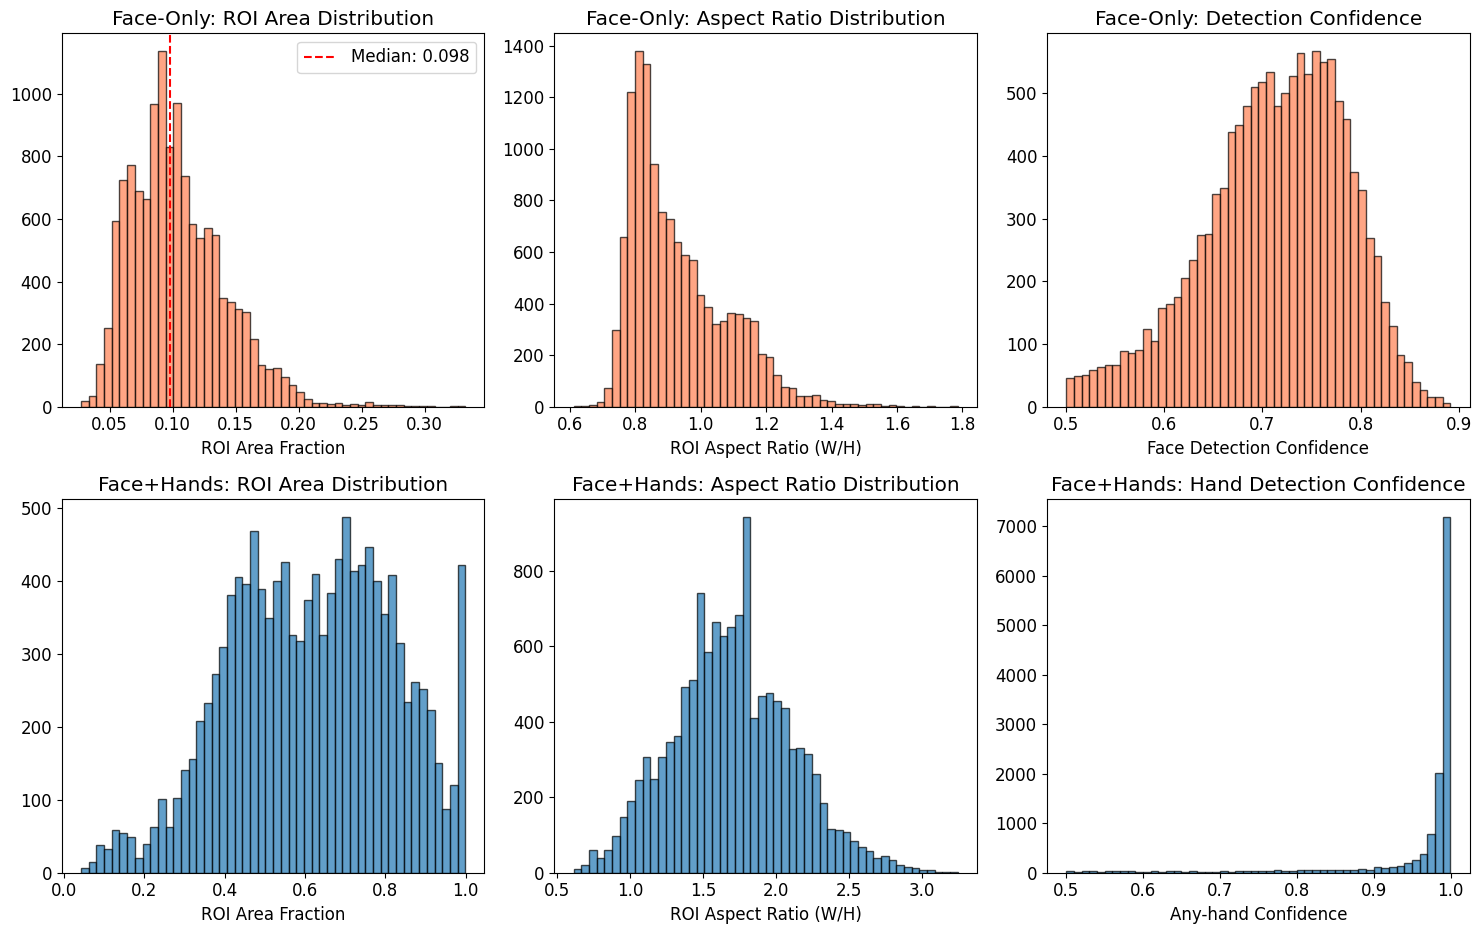

✅ Saved: /content/drive/MyDrive/TFM/outputs/metrics/crop_quality_distributions.png


In [ ]:
# 📊 ROI Quality Distribution Histograms (thesis figure)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

plt.rcParams.update({"font.size": 12})

meta_face = pd.read_csv(Path(OUT_ROOT) / "hybrid/detection_metadata_face.csv")
meta_fh = pd.read_csv(Path(OUT_ROOT) / "hybrid/detection_metadata_face_hands.csv")

face_valid = meta_face[meta_face["fallback_to_full"] == False].copy()
fh_valid = meta_fh[meta_fh["fallback_to_full"] == False].copy()

lh_conf = fh_valid["left_hand_confidence"].fillna(0).clip(lower=0)
rh_conf = fh_valid["right_hand_confidence"].fillna(0).clip(lower=0)
fh_valid["any_hand_conf"] = np.maximum(lh_conf, rh_conf)

fig, axes = plt.subplots(2, 3, figsize=(15, 9.5))

# Row 1: Face-only
axes[0, 0].hist(face_valid["roi_area_frac"], bins=50, alpha=0.7, color="coral", edgecolor="black")
axes[0, 0].set_xlabel("ROI Area Fraction")
axes[0, 0].set_title("Face-Only: ROI Area Distribution")
axes[0, 0].axvline(face_valid["roi_area_frac"].median(), color="red", linestyle="--",
                   label=f"Median: {face_valid['roi_area_frac'].median():.3f}")
axes[0, 0].legend()

axes[0, 1].hist(face_valid["roi_aspect"], bins=50, alpha=0.7, color="coral", edgecolor="black")
axes[0, 1].set_xlabel("ROI Aspect Ratio (W/H)")
axes[0, 1].set_title("Face-Only: Aspect Ratio Distribution")

axes[0, 2].hist(face_valid["face_confidence"], bins=50, alpha=0.7, color="coral", edgecolor="black")
axes[0, 2].set_xlabel("Face Detection Confidence")
axes[0, 2].set_title("Face-Only: Detection Confidence")

# Row 2: Face+Hands
axes[1, 0].hist(fh_valid["roi_area_frac"], bins=50, alpha=0.7, edgecolor="black")
axes[1, 0].set_xlabel("ROI Area Fraction")
axes[1, 0].set_title("Face+Hands: ROI Area Distribution")

axes[1, 1].hist(fh_valid["roi_aspect"], bins=50, alpha=0.7, edgecolor="black")
axes[1, 1].set_xlabel("ROI Aspect Ratio (W/H)")
axes[1, 1].set_title("Face+Hands: Aspect Ratio Distribution")

axes[1, 2].hist(fh_valid["any_hand_conf"], bins=50, alpha=0.7, edgecolor="black")
axes[1, 2].set_xlabel("Any-hand Confidence")
axes[1, 2].set_title("Face+Hands: Hand Detection Confidence")

plt.tight_layout()
plt.savefig(Path(OUT_ROOT) / "metrics/crop_quality_distributions.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"✅ Saved: {Path(OUT_ROOT) / 'metrics/crop_quality_distributions.png'}")


In [ ]:
# 📋 Fallback Reason Summary Table (for Thesis Appendix)
# Compares fallback reasons across face and face_hands variants

import pandas as pd
from pathlib import Path

# Load metadata for both variants
hybrid_root = Path(OUT_ROOT) / "hybrid"
meta_face = pd.read_csv(hybrid_root / "detection_metadata_face.csv")
meta_fh = pd.read_csv(hybrid_root / "detection_metadata_face_hands.csv")

def summarize_fallback_reasons(df, variant_name):
    """Summarize fallback reasons for a given variant."""
    total = len(df)
    fallbacks = df[df["fallback_to_full"] == True]
    n_fallback = len(fallbacks)
    n_valid = total - n_fallback

    # Count by reason
    reason_counts = fallbacks["fallback_reason"].value_counts().to_dict()

    # Build summary dict
    summary = {}
    for reason, count in reason_counts.items():
        pct = 100 * count / total
        summary[reason] = {"count": count, "pct": pct, "display": f"{count:,} ({pct:.1f}%)"}

    # Add totals
    summary["_total_fallback"] = {"count": n_fallback, "pct": 100 * n_fallback / total, "display": f"{n_fallback:,} ({100 * n_fallback / total:.1f}%)"}
    summary["_valid_crops"] = {"count": n_valid, "pct": 100 * n_valid / total, "display": f"{n_valid:,} ({100 * n_valid / total:.1f}%)"}
    summary["_total"] = {"count": total, "pct": 100.0, "display": f"{total:,}"}

    return summary

# Get summaries for both variants
face_summary = summarize_fallback_reasons(meta_face, "face")
fh_summary = summarize_fallback_reasons(meta_fh, "face_hands")

# Collect all unique reasons (excluding special keys)
all_reasons = set(face_summary.keys()) | set(fh_summary.keys())
fallback_reasons = sorted([r for r in all_reasons if not r.startswith("_")])

# Build comparison table
rows = []
for reason in fallback_reasons:
    face_data = face_summary.get(reason, {"count": 0, "pct": 0.0, "display": "0 (0.0%)"})
    fh_data = fh_summary.get(reason, {"count": 0, "pct": 0.0, "display": "0 (0.0%)"})
    rows.append({
        "Fallback Reason": reason,
        "Face": face_data["display"],
        "Face+Hands": fh_data["display"],
        "_face_count": face_data["count"],
        "_fh_count": fh_data["count"],
    })

# Add summary rows
rows.append({
    "Fallback Reason": "TOTAL FALLBACKS",
    "Face": face_summary["_total_fallback"]["display"],
    "Face+Hands": fh_summary["_total_fallback"]["display"],
    "_face_count": face_summary["_total_fallback"]["count"],
    "_fh_count": fh_summary["_total_fallback"]["count"],
})
rows.append({
    "Fallback Reason": "VALID CROPS",
    "Face": face_summary["_valid_crops"]["display"],
    "Face+Hands": fh_summary["_valid_crops"]["display"],
    "_face_count": face_summary["_valid_crops"]["count"],
    "_fh_count": fh_summary["_valid_crops"]["count"],
})
rows.append({
    "Fallback Reason": "TOTAL IMAGES",
    "Face": face_summary["_total"]["display"],
    "Face+Hands": fh_summary["_total"]["display"],
    "_face_count": face_summary["_total"]["count"],
    "_fh_count": fh_summary["_total"]["count"],
})

# Create DataFrame for display
summary_df = pd.DataFrame(rows)
display_df = summary_df[["Fallback Reason", "Face", "Face+Hands"]]

# Save to CSV (with raw counts for further analysis)
metrics_dir = Path(OUT_ROOT) / "metrics"
metrics_dir.mkdir(parents=True, exist_ok=True)
csv_path = metrics_dir / "fallback_summary.csv"
summary_df.to_csv(csv_path, index=False)
print(f"✅ Saved CSV: {csv_path}")

# Save styled HTML for thesis appendix
html_path = metrics_dir / "fallback_summary.html"
styled_html = display_df.style.set_table_styles([
    {"selector": "th", "props": [("background-color", "#f0f0f0"), ("font-weight", "bold"), ("text-align", "left"), ("padding", "8px")]},
    {"selector": "td", "props": [("padding", "6px 12px"), ("text-align", "left")]},
    {"selector": "tr:nth-child(even)", "props": [("background-color", "#f9f9f9")]},
    {"selector": "tr:last-child", "props": [("font-weight", "bold"), ("border-top", "2px solid #333")]},
    {"selector": "tr:nth-last-child(2)", "props": [("font-weight", "bold")]},
    {"selector": "tr:nth-last-child(3)", "props": [("font-weight", "bold"), ("border-top", "1px solid #999")]},
]).hide(axis="index").to_html()
with open(html_path, "w") as f:
    f.write(styled_html)
print(f"✅ Saved HTML: {html_path}")

# Display table
print("\n📋 FALLBACK REASON SUMMARY (Face vs Face+Hands)")
print("=" * 65)
print(display_df.to_string(index=False))
print("=" * 65)
print("\n💡 Use the HTML file for your thesis appendix (styled table).")


## ✅ Data Preparation Complete!

**What was created (persists on Drive):**
- `OUT_ROOT/manifests/manifest.csv` — Full image manifest
- `OUT_ROOT/splits/train.csv`, `val.csv`, `test.csv` — Split CSVs
- `OUT_ROOT/hybrid/face/` — Face-only crops
- `OUT_ROOT/hybrid/face_hands/` — Face+hands crops
- `OUT_ROOT/hybrid/*.csv` — Hybrid manifests and splits
- `OUT_ROOT/metrics/` — Quality audit figures

**Tar Archives (for fast loading):**
- `DRIVE_DATA_ROOT/full_compressed.tar` — Compressed full-frame images
- `OUT_ROOT/hybrid/hybrid_face.tar` — Face-only crops archive
- `OUT_ROOT/hybrid/hybrid_face_hands.tar` — Face+hands crops archive

**⚡ Performance Note:**
Future sessions will copy tar archives (~5 min) instead of individual files (~2 hours).

**Next steps:**
- Run **02_training.ipynb** to train models on these crops


In [2]:
# 📊 DIAGNOSTIC: Why is Avg Face Confidence the same for both variants?
# Run this in colab_setup_extractions_stats.ipynb after loading metadata
import pandas as pd
import numpy as np
from pathlib import Path

# Load metadata for both variants
hybrid_root = Path(OUT_ROOT) / "hybrid"
meta_face = pd.read_csv(hybrid_root / "detection_metadata_face.csv")
meta_fh = pd.read_csv(hybrid_root / "detection_metadata_face_hands.csv")

# Define valid crops (non-fallback)
face_valid = meta_face[meta_face["fallback_to_full"] == False].copy()
fh_valid = meta_fh[meta_fh["fallback_to_full"] == False].copy()

# =============================================================================
# STEP 1: Check precision — are they really the same or just rounded?
# =============================================================================
mean_face_only = face_valid["face_confidence"].mean()
mean_face_hands = fh_valid["face_confidence"].mean()

print("=" * 80)
print("🔬 STEP 1: Check Precision (are they identical or just rounded?)")
print("=" * 80)
print(f"Face-Only Mean Face Confidence:  {mean_face_only:.10f}")
print(f"Face+Hands Mean Face Confidence: {mean_face_hands:.10f}")
print(f"Difference (absolute):           {abs(mean_face_only - mean_face_hands):.10f}")
print()

if abs(mean_face_only - mean_face_hands) < 1e-9:
    print("⚠️  Values are IDENTICAL to 10 decimal places!")
    print("    → This suggests either a bug OR exact subset relationship.")
else:
    print(f"✅ Values differ by {abs(mean_face_only - mean_face_hands):.6f}")
    print(f"   → Rounded: {mean_face_only:.3f} vs {mean_face_hands:.3f}")

# =============================================================================
# STEP 2: Compare which images are in each valid set
# =============================================================================
print("\n" + "=" * 80)
print("🔬 STEP 2: Compare Image Sets")
print("=" * 80)

# Use original_path as the unique identifier
face_valid_ids = set(face_valid["original_path"].values)
fh_valid_ids = set(fh_valid["original_path"].values)

both_valid = face_valid_ids & fh_valid_ids
face_only_valid = face_valid_ids - fh_valid_ids  # Valid in face-only but not face+hands
fh_only_valid = fh_valid_ids - face_valid_ids    # Valid in face+hands but not face-only

print(f"Valid in Face-Only:       {len(face_valid_ids):,}")
print(f"Valid in Face+Hands:      {len(fh_valid_ids):,}")
print(f"Valid in BOTH:            {len(both_valid):,}")
print(f"Valid in Face-Only ONLY:  {len(face_only_valid):,} (excluded from Face+Hands)")
print(f"Valid in Face+Hands ONLY: {len(fh_only_valid):,} (excluded from Face-Only)")

# =============================================================================
# STEP 3: Check face_confidence for different subsets
# =============================================================================
print("\n" + "=" * 80)
print("🔬 STEP 3: Face Confidence by Subset")
print("=" * 80)

# Images valid in both
both_df = face_valid[face_valid["original_path"].isin(both_valid)]
mean_both = both_df["face_confidence"].mean()

# Images valid in face-only but excluded from face+hands
face_exclusive_df = face_valid[face_valid["original_path"].isin(face_only_valid)]
mean_face_exclusive = face_exclusive_df["face_confidence"].mean() if len(face_exclusive_df) > 0 else np.nan

# Images valid in face+hands but excluded from face-only
fh_exclusive_df = fh_valid[fh_valid["original_path"].isin(fh_only_valid)]
mean_fh_exclusive = fh_exclusive_df["face_confidence"].mean() if len(fh_exclusive_df) > 0 else np.nan

print(f"Avg Face Conf (both valid):          {mean_both:.6f} (n={len(both_df):,})")
print(f"Avg Face Conf (face-only exclusive): {mean_face_exclusive:.6f} (n={len(face_exclusive_df):,})")
print(f"Avg Face Conf (face+hands exclusive):{mean_fh_exclusive:.6f} (n={len(fh_exclusive_df):,})")

# =============================================================================
# STEP 4: Verify the computation definition
# =============================================================================
print("\n" + "=" * 80)
print("🔬 STEP 4: Verify Computation Definition")
print("=" * 80)

# Check: is face_confidence the same for the same image in both metadata files?
common_paths = list(both_valid)[:100]  # Sample 100 common images
face_subset = meta_face[meta_face["original_path"].isin(common_paths)].set_index("original_path")
fh_subset = meta_fh[meta_fh["original_path"].isin(common_paths)].set_index("original_path")

conf_face = face_subset.loc[common_paths, "face_confidence"].values
conf_fh = fh_subset.loc[common_paths, "face_confidence"].values

all_same = np.allclose(conf_face, conf_fh, atol=1e-6)
print(f"Face confidence values identical between metadata files? {all_same}")
if all_same:
    print("   ✅ Confirmed: Same face detector used for both variants.")
    print("   → The difference is only in which images pass the valid crop filter.")
else:
    print("   ⚠️  Values differ! This is unexpected and may indicate a bug.")

# =============================================================================
# STEP 5: Why do the means look the same? Distribution analysis
# =============================================================================
print("\n" + "=" * 80)
print("🔬 STEP 5: Why Means Look Similar")
print("=" * 80)

# The key insight: if the excluded images have similar confidence to included ones,
# the mean won't change much.
if len(face_exclusive_df) > 0:
    print(f"\nImages excluded from Face+Hands (but valid in Face-Only):")
    print(f"   Count: {len(face_exclusive_df)}")
    print(f"   Mean face_confidence: {mean_face_exclusive:.6f}")
    print(f"   vs Overall Face-Only mean: {mean_face_only:.6f}")
    print(f"   Delta: {mean_face_exclusive - mean_face_only:.6f}")

    if abs(mean_face_exclusive - mean_face_only) < 0.01:
        print("\n   → The excluded images have SIMILAR face confidence to the rest!")
        print("     This explains why the overall mean barely changes.")
    else:
        print("\n   → The excluded images have DIFFERENT face confidence.")
        print("     The means should differ more noticeably.")

# =============================================================================
# SUMMARY TABLE (with high precision)
# =============================================================================
print("\n" + "=" * 80)
print("📋 SUMMARY TABLE (High Precision)")
print("=" * 80)
print(f"{'Metric':<40} {'Face-Only':>15} {'Face+Hands':>15}")
print("-" * 70)
print(f"{'Total Images':<40} {len(meta_face):>15,} {len(meta_fh):>15,}")
print(f"{'Valid Crops':<40} {len(face_valid):>15,} {len(fh_valid):>15,}")
print(f"{'Excluded Count':<40} {len(meta_face) - len(face_valid):>15,} {len(meta_fh) - len(fh_valid):>15,}")
print(f"{'Avg Face Confidence (6 decimals)':<40} {mean_face_only:>15.6f} {mean_face_hands:>15.6f}")
print(f"{'Avg Face Confidence (rounded to 3)':<40} {mean_face_only:>15.3f} {mean_face_hands:>15.3f}")
print("-" * 70)

🔬 STEP 1: Check Precision (are they identical or just rounded?)
Face-Only Mean Face Confidence:  0.7126591059
Face+Hands Mean Face Confidence: 0.7129848456
Difference (absolute):           0.0003257397

✅ Values differ by 0.000326
   → Rounded: 0.713 vs 0.713

🔬 STEP 2: Compare Image Sets
Valid in Face-Only:       12,997
Valid in Face+Hands:      12,729
Valid in BOTH:            12,728
Valid in Face-Only ONLY:  269 (excluded from Face+Hands)
Valid in Face+Hands ONLY: 1 (excluded from Face-Only)

🔬 STEP 3: Face Confidence by Subset
Avg Face Conf (both valid):          0.712994 (n=12,728)
Avg Face Conf (face-only exclusive): 0.696813 (n=269)
Avg Face Conf (face+hands exclusive):0.596400 (n=1)

🔬 STEP 4: Verify Computation Definition
Face confidence values identical between metadata files? True
   ✅ Confirmed: Same face detector used for both variants.
   → The difference is only in which images pass the valid crop filter.

🔬 STEP 5: Why Means Look Similar

Images excluded from Face+Hands